# RNNs Tutorial with PyTorch on the IMDB Dataset

In this tutorial, we will build a Recurrent Neural Network (CNN) to classify movie reviews as positive or negative using the IMDB dataset.
 
We'll go through the following steps:

1. **Data Loading, Processing, and Augmentation**
2. **Data Exploration**
3. **Model Building**
4. **Model Training**
5. **Model Evaluation**



## 1. Data Loading, Processing, and Augmentation

The IMDB dataset contains 50,000 movie reviews, split into 25,000 reviews for training and 25,000 reviews for testing. The dataset is preprocessed, and each review is encoded as a sequence of word indexes.

### Exercise 1.1 - Data Loading and Processing

1. Load the data from `'../../data/imdb_dataset.zip'` using pandas.
2. Convert the `sentiment` column to a binary label (0 for negative and 1 for positive).
3. Split the dataset into training and test sets (25,000 samples each).
4. Preprocess the `review` column by converting it to lowercase and removing special characters, punctuation and stopwords. Additionally, use a stemming or lemmatization technique.
5. Build a vocabulary of unique words in the training dataset.
6. Tokenize the reviews using the vocabulary, i.e., replace each word with its index in the vocabulary. Note that the reviews should be padded to a fixed length.
7. Create the data loaders for training and test datasets.


In [94]:
import modin.pandas as pd

df = pd.read_csv('../../data/imdb_dataset.zip', compression='zip')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [95]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [96]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.5, random_state=42, stratify=df['sentiment'])

train.shape, test.shape

((25000, 2), (25000, 2))

In [97]:
train['sentiment'].value_counts(), test['sentiment'].value_counts()

(sentiment
 0    12500
 1    12500
 Name: count, dtype: int64,
 sentiment
 0    12500
 1    12500
 Name: count, dtype: int64)

In [98]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
train.head

<bound method BasePandasDataset.head of                                                   review  sentiment
3055   Trio's vignettes were insightful and quite enj...          1
47326  I had never heard of this one before the owner...          0
48869  This is an excellent but hard to find trippy W...          1
48623  I am a huge fan of big, loud, trashy, complete...          1
39657  Easily Lucio Fulci's most respected film, "Don...          1
...                                                  ...        ...
21552  Recent years have seen a number of biopics of ...          1
10610  You may say to yourself, "Don Johnson as Elvis...          0
20104  The title refers not to a questionable poker h...          1
35597  this is by far the most pathetic movie Indian ...          0
27491  This movie forever left an impression on me. I...          0

[25000 rows x 2 columns]>

In [100]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\W+', ' ', text)  # Remove non-word/non-whitespace characters
    text = re.sub(r'\d+', '', text)  # Remove digits
    tokens = [word for word in text.split()]  # Tokenize text
    words = [word for word in tokens if word not in stop_words]  # Remove stop words
    words = [stemmer.stem(word) for word in words]  # Perform stemming
    return ' '.join(words)

In [101]:
train['prepoc_review'] = train['review'].apply(preprocess_text)
test['prepoc_review'] = test['review'].apply(preprocess_text)

train.head()

,review,sentiment,prepoc_review
3055,Trio's vignettes were insightful and quite enj...,1,trio vignett insight quit enjoy curiou see man...
47326,I had never heard of this one before the owner...,0,never heard one owner local dvd rental outlet ...
48869,This is an excellent but hard to find trippy W...,1,excel hard find trippi world war spi thriller ...
48623,"I am a huge fan of big, loud, trashy, complete...",1,huge fan big loud trashi complet stupid action...
39657,"Easily Lucio Fulci's most respected film, ""Don...",1,easili lucio fulci respect film tortur duckl h...


In [111]:
def tokenize_text(text):
    return word_tokenize(text)

train['tokens'] = train['prepoc_review'].apply(tokenize_text)

In [115]:
top5000 = pd.Series([word for tokens in train['tokens'] for word in tokens]).value_counts()[:5000]

top5000

br               99890
movi             51648
film             48360
one              27870
like             22425
                 ...  
spous               58
baron               58
kristofferson       58
redund              58
lightn              58
Name: count, Length: 5000, dtype: int64

In [104]:
# ...

In [115]:
# ...

### Exercise 1.2 - Data Augmentation

1. Define a function to replace random words with synonyms from WordNet in the reviews.
2. Augment the training dataset by replacing words in a few reviews with synonyms.

Note: Never augment the test dataset. It's essential to evaluate the model on the original data.

In [116]:
import random
from nltk.corpus import wordnet
import nltk

nltk.download('wordnet')

def augment_text(text, max_augment=3):
    tokens = text.split()[:20]
    augmented_tokens = tokens.copy()
    
    for _ in range(max_augment):
        if len(augmented_tokens) > 1:
            rand_idx = random.randint(0, len(augmented_tokens) - 1)
            word = augmented_tokens[rand_idx]
            synonyms = wordnet.synsets(word)
            if synonyms:
                replacement = random.choice(synonyms).lemmas()[0].name()
                augmented_tokens[rand_idx] = replacement
    print(f"Original: {' '.join(tokens)}")
    print(f"Augmented: {' '.join(augmented_tokens)}")
    print('\n\n')
    return ' '.join(augmented_tokens)

# Apply augmentation to training set
train_df['review'].iloc[:3].apply(lambda x: augment_text(x, max_augment=3))

Original: "Congo" is based on the best-selling novel by Michael Crichton, which I thought lacked Crichton's usual charm, smart characters and
Augmented: "Congo" is based on the best-selling novel by Michael Crichton, which I thought lacked Crichton's usual charm, smart character and



Original: Wow, here it finally is; the action "movie" without action. In a real low-budget setting (don't miss the hilarious flying
Augmented: Wow, here it finally is; the action "movie" without action. In a real low-budget setting (don't miss the hilarious flying



Original: 'Identity . . . . I am part of my surroundings and I became separate from them and it's being
Augmented: 'Identity . . . . I am part of my surroundings and I became separate from them and it's exist





[nltk_data] Downloading package wordnet to /home/joao-
[nltk_data]     correia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


25858    "Congo" is based on the best-selling novel by ...
10784    Wow, here it finally is; the action "movie" wi...
24807    'Identity . . . . I am part of my surrounding...
Name: review, dtype: object

## 2. Data Exploration

Before training our model, it's essential to explore the data. This helps us understand its distribution and visualize some examples.

### Exercise 2 - Data Exploration
1. Print the number of positive and negative reviews in the training and test datasets.
2. Plot a histogram of the length of reviews in the training and test datasets.
3. Print a few reviews and their corresponding sentiment labels.

In [117]:
# ...

(sentiment
 0    12517
 1    12483
 Name: count, dtype: int64,
 sentiment
 1    12517
 0    12483
 Name: count, dtype: int64)

(array([3.0260e+03, 1.0931e+04, 4.7480e+03, 2.4410e+03, 1.3860e+03,
        9.0700e+02, 5.3200e+02, 3.6400e+02, 2.6400e+02, 1.7100e+02,
        1.2300e+02, 6.9000e+01, 1.7000e+01, 6.0000e+00, 3.0000e+00,
        3.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   4.        ,   52.36666667,  100.73333333,  149.1       ,
         197.46666667,  245.83333333,  294.2       ,  342.56666667,
         390.93333333,  439.3       ,  487.66666667,  536.03333333,
         584.4       ,  632.76666667,  681.13333333,  729.5       ,
         777.86666667,  826.23333333,  874.6       ,  922.96666667,
         971.33333333, 1019.7       , 1068.06666667, 1116.43333333,
        1164.8       , 1213.16666667, 1261.53333333, 1309.9       ,
        1358.26666667, 1406.63333333, 1455.        ]),
 <BarContainer object of 30 artists>)

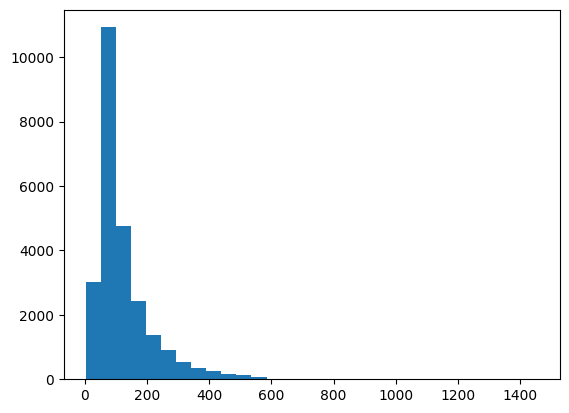

In [118]:
# length of reviews (histogram)
import matplotlib.pyplot as plt

# ...

(array([2.124e+03, 8.784e+03, 5.773e+03, 2.861e+03, 1.838e+03, 1.132e+03,
        7.550e+02, 5.450e+02, 3.500e+02, 2.590e+02, 1.810e+02, 1.680e+02,
        1.160e+02, 6.900e+01, 3.300e+01, 7.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([   3. ,   43.4,   83.8,  124.2,  164.6,  205. ,  245.4,  285.8,
         326.2,  366.6,  407. ,  447.4,  487.8,  528.2,  568.6,  609. ,
         649.4,  689.8,  730.2,  770.6,  811. ,  851.4,  891.8,  932.2,
         972.6, 1013. , 1053.4, 1093.8, 1134.2, 1174.6, 1215. ]),
 <BarContainer object of 30 artists>)

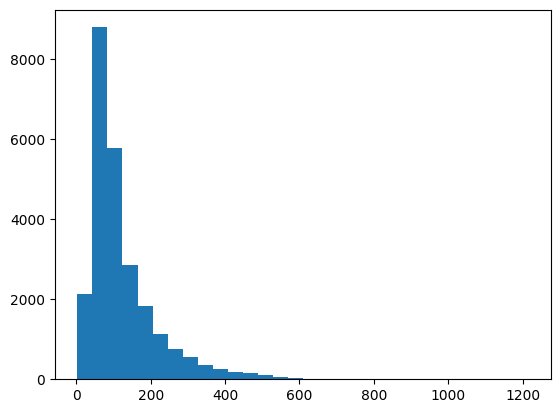

In [119]:
# ...

In [120]:
# print reviews and sentiment labels
# ...

Review: "Congo" is based on the best-selling novel by Michael Crichton, which I thought lacked Crichton's usual charm, smart characters and punch. Well, sorry to say, but the same goes for the film.<br /><br />Here's the plot:<br /><br />Greed is bad, this simple morality tale cautions. A megalomaniacal C.E.O. (Joe Don Baker) sends his son into the dangerous African Congo on a quest for a source of diamonds large enough and pure enough to function as powerful laser communications transmitter (or is it laser weapons?). When contact is lost with his son and the team, his daughter-in-law (Laura Linney), a former CIA operative and computer-freak, is sent after them. On her quest, she is accompanied by gee-whiz gadgetry and a few eccentric characters (including a mercenary (Ernie Hudson), a researcher with a talking gorilla (Dylan Walsh), and a a nutty Indiana-Jones-type looking for King Solomon's Mines (Tim Curry). After some narrow escapes from surface-to-air missiles and some African wil

## 3. Model Building

Now, we'll define our RNN architecture. A typical RNN consists of an embedding layer, RNN layers, and a fully connected layers.

### Exercise
1. Define a RNN class inheriting from torch.nn.Module.
2. Include one Embedding layer, two LSTM layers, and two Linear layers.

In [121]:
# ...

RNNModel(
  (embedding): Embedding(5002, 128)
  (rnn): LSTM(128, 64, batch_first=True)
  (rnn2): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## 4. Model Training

We'll now define the training loop to optimize our model using the binary cross-entropy loss function and the Adam optimizer.

### Exercise
1. Define a function to train the model for a specified number of epochs.
2. Print the training loss after each epoch.

In [122]:
# ...

Epoch 1/5, Loss: 0.6930, Accuracy: 49.93%
Epoch 2/5, Loss: 0.6912, Accuracy: 49.93%
Epoch 3/5, Loss: 0.6129, Accuracy: 49.93%
Epoch 4/5, Loss: 0.4670, Accuracy: 49.93%
Epoch 5/5, Loss: 0.3798, Accuracy: 49.93%


## 5. Model Evaluation

After training, we need to evaluate our model on the test dataset to understand its performance.

### Exercise
1. Define a function to evaluate the model's accuracy on the test set.
2. Print the accuracy.

In [81]:
# ...

Test Accuracy: 50.07%
